# Optimizacion con MAPL

$ G_{i} \leftarrow train(\{(Hr_{n}^{b}, LR_{n}^{b})\}_i) \hspace{1cm}  (\forall n=1,2 ... n\_samples) (\forall b \in Bvals) $
 
$ \hspace{5.5cm} LR_n = downsampling(HR_n) $

$ M, C \leftarrow mapl(Y^{lr}.gtab) $

$ \min_{Yhr, C^{hr}} \{ \left( \sum_{i}^{Nb} ||G^{b}Yhr^{b} - Ylr^{b}||^2 \right) + || Yhr - M*C^{hr} || + ||C||_{1} \}$


In [1]:
%pylab inline
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mat_utils
#import nibabel as nib
import mapmri.mapmri as mp
#from dipy.core.gradients import gradient_table
import cvxpy as cvx
reload(img_utils)
import load.hcp_img_loader as hcp

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_sample_dwi(index, numbers, loader_func, bval=None, bvalpos=None,  scale=2):
    # Load Hcp subject
    img, gtab, idxs = loader_func(index, numbers, bval, bvalpos)
    # Downsample data
    lr, _ = img_utils.downsampling(img, scale)
    data = img.get_data()
    data_noS0 =data[:,:,:, idxs]
    s0_idxs = [ i for i in xrange(max(idxs)+1)  if i not in idxs] 
    return data_noS0, lr[:,:,:, idxs], data[:,:,:,s0_idxs], lr[:, :, :, s0_idxs], gtab

def get_sample(index, numbers, loader_func, bval=None, bvalpos=None,  scale=2):
    hr, lr, S0hr, S0lr, gtab = get_sample_dwi(index, numbers, loader_func, bval=None, bvalpos=None,  scale=2)
    
    hr = get_atenuation(hr, S0hr)
    lr = get_atenuation(lr, S0lr)
    del(S0hr, S0lr)
    return hr, lr, gtab



def get_sample_c(index, numbers, loader_func, bval=None, bvalpos=None,  scale=2, multiply_S0=False):
    hr, lr, S0hr, S0lr, gtab = get_sample_dwi(index, numbers, loader_func, bval=None, bvalpos=None,  scale=2)
    # Calculate MAPL  C_hr:(Nx,Ny,Nz,Nc) c_lr:(nx,ny,nz,nc)
    C_hr = getC(hr, gtab, radial_order = 4)
    c_lr = getC(lr, gtab, radial_order = 4)
    
    # Multiply by S0 to get the signal (and not the atenuation)
    if multiply_S0 :
        C_hr = get_signal(C_hr, S0hr)
        c_lr = get_signal(c_lr, S0lr)
    
    # Clean-up
    del(hr)
    del(lr)
    del(S0hr)
    del(S0lr)
    return C_hr, c_lr, gtab
    
"""
def get_sample_mapl(index, numbers, loader_func, bval=None, bvalpos=None,  scale=2, multiply_S0=False):
    hr, lr, S0hr, S0lr, gtab = get_sample_dwi(index, numbers, loader_func, bval=None, bvalpos=None,  scale=2)
    # Calculate MAPL  C_hr:(Nx,Ny,Nz,Nc) c_lr:(nx,ny,nz,nc)
    C_hr = getC(hr, gtab, radial_order = 4)
    c_lr = getC(lr, gtab, radial_order = 4)
    
    # Multiply by S0 to get the signal (and not the atenuation)
    if multiply_S0 :
        C_hr = get_signal(C_hr, S0hr)
        c_lr = get_signal(c_lr, S0lr)
    
    # Clean-up
    del(hr)
    del(lr)
    del(S0hr)
    del(S0lr)
    return C_hr, c_lr, gtab
"""
def get_sample_maker(numbers, loader_func, bval=None, bvalpos=None, scale=2):
    return lambda index : get_sample(index, numbers, loader_func, bval, bvalpos,  scale)

def mm(A, cast_int=True):
    if cast_int :
        return (int(A.min()), int(A.max()))
    else:
        return (A.min(), A.max())
    
def buildT(sample_getter, n_samples):
    C, c, _ = sample_getter(0)
    X = img_utils.column_this(c)
    Y = img_utils.column_this(C)
    for i in range(1, n_samples):
        noised_hr, noised_lr, _ = sample_getter(i)
        X = img_utils.append_column(X, c)
        Y = img_utils.append_column(Y, C)
    return X, Y


def buildT_grouping_by_q(sample_getter, n_samples, bvals_needed):
    """
    Genera tantos conjuntos de entrenamiento como 
    bvals distintos tenga el volumne
    """
    hr, lr, gtab = sample_getter(0)
    bs = bvals_needed[0:hr.shape[3]]
    
    dicX = split_by_bval(lr, bs, gtab)
    dicY = split_by_bval(hr, bs, gtab)
    for i in range(1, n_samples):
        hr, lr, gtab = sample_getter(i)
        dicX = split_by_bval(lr, bs, gtab, dicX)
        dicY = split_by_bval(hr, bs, gtab, dicY)
    return dicX, dicY

def split_by_bval(img, bvals_needed, gtab, res=None):
    """
    Dada una imagen separa la cuarta dimension segun su vbal
    Y por cada una hace un vector columna
    """
    if res is None:
        res = dict((b, None) for b in bvals_needed)
        
    for i in xrange(len(gtab.bvals)):
        b = gtab.bvals[i]
        if b not in bvals_needed :
            continue
        
        XorY = res[b]
        if XorY is None:
            res[b] = img_utils.column_this(img[:,:,:,i])
        else:
            res[b] = img_utils.append_column(XorY, img[:,:,:,i])
    return res

def buildT_grouping_by_c(sample_getter, n_samples):
    """
    Genera tantos conjuntos de entrenamiento coef de MAPL
    """
    C, c, _ = sample_getter(0)
    dicX = split_by_coef(c)
    dicY = split_by_coef(C)
    for i in range(1, n_samples):
        C, c, _ = sample_getter(i)
        dicX = split_by_coef(c, dicX)
        dicY = split_by_coef(C, dicY)
    return dicX, dicY

def split_by_coef(img, res=None):
    """
    Dada una imagen separa la cuarta dimension segun su coef de MAPL
    """
    Nc = img.shape[3]
    if res is None:
        res = dict((coef, None) for coef in xrange(Nc))
        
    for c in xrange(Nc):
        XorY = res[c]
        if XorY is None:
            res[c] = img_utils.column_this(img[:,:,:,c])
        else:
            res[c] = img_utils.append_column(XorY, img[:,:,:,c])
    return res

def get_atenuation(Sq, S0):
    _S0 = S0
    if len(S0.shape) > 3 :
        _S0 = S0.mean(axis=3)
    for b in xrange(Sq.shape[3]):
        Sq[:,:,:,b] = np.divide(Sq[:,:,:,b], _S0)
    return Sq

def get_signal(Eq, S0):
    _S0 = S0
    if len(S0.shape) > 3 :
        _S0 = S0.mean(axis=3)
    for b in xrange(Eq.shape[3]):
        Eq[:,:,:,b] = np.multiply(Eq[:,:,:,b], _S0)
    return Eq
    

## Example of use
#buildT(get_sample_maker(numbers, scale), n_samples)

## MapMri

In [3]:
def getC(data, gtab, radial_order = 4):
    Nx, Ny, Nz, Nb = data.shape
    vhr =Nx*Ny*Nz
    map_model = mp.MapmriModel(gtab,
                                radial_order=radial_order,
                                laplacian_regularization=True,
                                laplacian_weighting=0.2,
                                anisotropic_scaling=False,
                                dti_scale_estimation=False)
    map_model_fit = map_model.fit(data)
    # (Nx, Ny, Nz, Nc)
    C = map_model_fit.mapmri_coeff
    return C

def getMAndU(radial_order, mu, gtab, tau):
    r'''Recovers the reconstructed signal for any qvalue array or
        gradient table.
        '''
    qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
    q = qvals[:, None] * gtab.bvecs
    M = mp.mapmri_isotropic_phi_matrix(radial_order, mu[0], q)
    
    # Lapalcian matrix
    laplacian_matrix = mp.mapmri_isotropic_laplacian_reg_matrix(radial_order, 1.)
    laplacian_matrix = laplacian_matrix * mu[0]
    
    return M, laplacian_matrix
    
def getM(radial_order, mu, gtab, tau):
    r'''Recovers the reconstructed signal for any qvalue array or
        gradient table.
        '''
    qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
    q = qvals[:, None] * gtab.bvecs
    M = mp.mapmri_isotropic_phi_matrix(radial_order, mu[0], q)
    return  M

def get_mapl_params(gtab, radial_order = 4):
    #Fiteo el model
    map_model = mp.MapmriModel(gtab,
                                radial_order=radial_order,
                                laplacian_regularization=True,
                                laplacian_weighting=0.2,
                                anisotropic_scaling=False,
                                dti_scale_estimation=False)
    # Fiteo la data
    #map_model_fit = map_model.fit(i_hr)
    tau = map_model.tau
    mu = map_model.mu
    print 'mu.shape', mu.shape
    M = getM(radial_order, mu, gtab, tau)
    return M, tau, mu    
    
def get_mapl_params2(gtab, radial_order = 4):
    #Fiteo el model
    map_model = mp.MapmriModel(gtab,
                                radial_order=radial_order,
                                laplacian_regularization=True,
                                laplacian_weighting=0.2,
                                anisotropic_scaling=False,
                                dti_scale_estimation=False)
    # Fiteo la data
    #map_model_fit = map_model.fit(i_hr)
    tau = map_model.tau
    mu = map_model.mu
    print 'mu.shape', mu.shape, mu
    M, U = getMAndU(radial_order, mu, gtab, tau)
    return M, tau, mu, U    
    

# 3D Tv-Norm

$ \sum_{ijk \in positions(I)} \left|\left| (I_{i,j,k}, I_{i,j,k}, I_{i,j,k}) - ( I_{i-1,j,k}, I_{i,j-1,k},  I_{i,j,k-1}) \right|\right| $

In [4]:
from cvxpy.expressions.expression import Expression
from cvxpy.atoms.elementwise.norm2_elemwise import norm2_elemwise

def tv3d_CubosYSlices(value, *args):
    value = Expression.cast_to_const(value)
    rows, cols = value.size
    if value.is_scalar():
        raise ValueError("tv cannot take a scalar argument.")
    # L1 norm for vectors.
    elif value.is_vector():
        return ValueError("You may call tv.")
    # L2 norm for matrices.
    else:
        args = map(Expression.cast_to_const, args)
        slices = [value] + list(args)
        
        Nz = len(slices)
        Nx, Ny = slices[0].size
        if Nz < 2 or Nx < 2 or Ny < 2:
            return ValueError("You may call tv.")
        
        norm2_slices = []
        cub_k, cub_x, cub_y, cub_z = [], [], [], []
        
        for z in range(0, Nz-1):
            mat= slices[z]  
            cub_k.append(cvx.vec(mat[0:Nx-1, 0:Ny-1]))
            cub_x.append(cvx.vec(mat[1:Nx, 0:Ny-1]))
            cub_y.append(cvx.vec(mat[0:Nx-1, 1:Ny]))
        
        for z in range(1, Nz):
            mat= slices[z]  
            cub_z.append(cvx.vec(mat[0:Nx-1, 0:Ny-1]))
        
        K = cvx.vstack(*cub_k)
        X = cvx.vstack(*cub_x)
        Y = cvx.vstack(*cub_y)
        Z = cvx.vstack(*cub_z)
        
        diffs = []
        diffs += [
            X - K,
            Y - K,
            Z - K,
        ]
        norm2 = norm2_elemwise(*diffs)
        
        return cvx.sum_entries(norm2)

def call_tv3d_CubosYSlices(Yhr, Nx, Ny, Nz, bval):
    vhr = Nx*Ny*Nz
    vhrb = vhr*bval
    Nxy = Nx*Ny
    b_offset = vhr
    tvs_by_b = []
    for b in xrange(bval):
        b_offset = b*vhr
        slices = []
        for z in range(0, Nz):
            XY = Yhr[b_offset + z*Nxy: b_offset + (z+1)*Nxy] # el slice XY para este z y b
            mat = cvx.reshape(XY, Nx, Ny)
            slices.append(mat)
        
        tvs_by_b.append(tv3d_CubosYSlices(*slices))
        #tvs_by_b.append(cvx.tv3d(*slices))
        
    print '#slices', len(slices)
    return sum(tvs_by_b)

def tv3d(Yhr, Nx, Ny, Nz, Nb):
    return call_tv3d_CubosYSlices(Yhr, Nx, Ny, Nz, Nb)

## Problem definition

$ \min_{C^{hr}} \{ ||GC^{hr} - C^{lr}||^2  + ||C||_{1} \}$


In [5]:
 def define_problem_with_mapl(i_lr, i_hr_shape, G, M, U, tau, gtab, scale, intercept=None):
    Nb, Nc = M.shape
    Nx, Ny, Nz, bval = i_hr_shape
    vlr = Nx*Ny*Nz/(scale**3)
    vlrb = vlr*bval
    vhr = Nx*Ny*Nz
    vhrb = vhr*bval
      
    ## Hr volumes
    Yhr = cvx.Variable(vhrb, 1, name='cvxYhr')
    #Yhr.value = np.ones((vhrb, 1))*i_lr.mean()
    
    ## MAPL params
    #cvxChr = cvx.Constant(C_hr.reshape(-1, order='F'))
    cvxChr = cvx.Variable(vhr*Nc, name='cvxChr')
    # M:(Nb,Nc)
    cvxMaplE = (M * cvx.reshape(cvxChr,vhr, Nc).T).T
    # Hr image in row by b-val
    YhrMapl = cvx.reshape(Yhr, vhr, bval)
    # Mapl dual expression
    cvxMaplDualExp = cvx.sum_squares(cvxMaplE-YhrMapl)
    
    ## Laplacian regularization
    cvxU = cvx.Constant(U)
    regLaplade_list = []
    vhrc = vhr*Nc
    for voxel in xrange(vhr):
        cvxLapaceReg = cvx.quad_form(cvxChr[voxel:vhrc:vhr], cvxU)
        regLaplade_list.append(cvxLapaceReg**2)
    cvxLaplaceRegExp = sum(regLaplade_list)
    
    ## LA FORMA MATRICIAL NO ME DEJA DICE QUE NO SE PUEDE MULTIPLICAR DOS MATRICES
    #  cvxChr:(vhrc, 1) U:(Nc,Nc)
    #cvxC_byCoef = cvx.reshape(cvxChr, vhr, Nc)
    #cvxCUC = cvx.diag(cvxC_byCoef*cvxU*cvxC_byCoef.T)
    #cvxLapaceRegExp = cvx.sum_squares(cvxCUC)


    
    
    ## Fidelity expression
    #cvxG = G
    fidelity_list = []
    lapace_list = []
    for i in xrange(Nb):
        b = gtab.bvals[i]
        b_offset_hr = i*vhr
        Yhr_b = Yhr[b_offset_hr:b_offset_hr+vhr]
        # Aprovecho para setearle un valor unicia
        Gb = cvx.Constant(G[b])
        Ylr_b = cvx.Constant(i_lr[b])
        if intercept is not None:
            cvxInt_b = cvx.Constant(intercept[b])
            #cvxInt_c:(vlr, 1)
            fid_b = cvx.sum_squares((Gb*Yhr_b+cvxInt_b) - Ylr_b.T)
        else:
            fid_b = cvx.sum_squares(Gb*Yhr_b - Ylr_b.T)
        fidelity_list.append(fid_b)    
    cvxFidelityExp = sum(fidelity_list)
    
    
    ## 3D Tv-Norm Regularization
    cvx3DTvNomExp = tv3d(Yhr, Nx, Ny, Nz, Nb)
    
    #Sparcity regularization
    cvxNorm1 = cvx.norm1(cvxChr)
    
    
    ## Mapl weight
    beta = cvx.Parameter(value=3*1.452e-15, name='beta', sign='positive')#3.197e-10
    ## Sparcity weight
    alpha = cvx.Parameter(value=1.627e-15, name='alpha', sign='positive')#4.865e-10
    ## Fidelity weight
    lamda = cvx.Parameter(value=1., name='lamda',sign='positive')
    ## 3D-Tv weight
    gamma = cvx.Parameter(value=2*1.627e-15, name='gamma',sign='positive')
    ### AS VARIABLES
    # beta = cvx.Variable(name='beta')
    # beta.value = 0.2
    ## Sparcity weight
    # alpha = cvx.Variable(name='alpha')
    # alpha.value = 4000
    ## Fidelity weight
    # gamma = cvx.Variable(name='gamma')
    # lamda = cvx.Variable(name='lamda')
    # lamda.value =0.5
    
    # Form objective.
    #obj = cvx.Minimize(cvxFidelityExp + betha*cvxLapaceRegExp + alpha*cvx.norm(cvxChr) + gamma*cvx3DTvNomExp)
    obj = cvx.Minimize(lamda*cvxFidelityExp + cvxMaplDualExp + beta*cvxLaplaceRegExp + alpha*cvxNorm1 + gamma*cvx3DTvNomExp)
         
    # Constraints
    #constraints = [lamda > 0 , alpha > 0, beta > 0]
    constraints = [Yhr >= 0]
    #Agregar q M*C es positivo o deberia

    # Form and solve problem.
    prob = cvx.Problem(obj, constraints)
    
    return prob, cvxFidelityExp ,  cvxLaplaceRegExp , cvxNorm1



In [6]:
def solveMin(i_lr, i_hr_shape, G, M, U, tau, gtab, intercept=None, scale=2, max_iters=1500, verbose=False, prob=None):
    Nx, Ny, Nz, Nb = i_hr_shape
    Nb, Nc = M.shape
    nx, ny, nz = Nx/scale, Ny/scale, Nz/scale 
    vhr, vlr = Nx*Ny*Nz, nx*ny*nz 
    
    cvxFidelityExp ,  cvxLaplaceRegExp , cvxNorm1 = None, None, None
    if prob is None :
        prob, cvxFidelityExp ,  cvxLaplaceRegExp , cvxNorm1 = define_problem_with_mapl(
                                    i_lr, 
                                    i_hr_shape, 
                                    G, 
                                    M, U,tau,
                                    gtab,
                                    scale,
                                    intercept=intercept)
     
    
    start_time = time.time()
    res = prob.solve(solver='SCS', max_iters=max_iters, eps=1.0e-03, verbose=verbose )  # Returns the optimal value.
    #res = prob.solve(solver='ECOS')  # Returns the optimal value.
    
    seg = time.time() - start_time

    minutes = int(seg / 60)
    print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
    print "--- status:", prob.status, "optimal value", prob.value
    print 

    variables = dict( (v.name(), v) for v in prob.variables())
    #parameters = dict( (v.name(), v) for v in prob.parameters())
    #print 'alpha=', variables['alpha'].value ,'beta=',  variables['beta'].value
    print variables
    #A, C = i_hr, C_hr
    
    cvxChr = variables['cvxChr']
    cvxYhr = variables['cvxYhr']
    
    # cvxChr: (vhrc, 1) M:(Nb,Nc)
    
    C = np.asarray(cvxChr.value, dtype='float32').reshape((Nx, Ny, Nz, Nc), order='F')

    A = np.asarray(cvxYhr.value, dtype='float32').reshape(i_hr_shape, order='F')
    
    Amapl = M.dot(C.reshape((Nx*Ny*Nz, Nc), order='F').T).T
    Amapl = Amapl.reshape((Nx, Ny, Nz, Nb), order='F')
    
    print 'cvxFidelityExp', cvxFidelityExp.value   
    print 'cvxLaplaceRegExp', cvxLaplaceRegExp.value
    print 'cvxNorm1', cvxNorm1.value 
    
    return A, Amapl, C, seg, prob, cvxFidelityExp, cvxLaplaceRegExp , cvxNorm1

## Solving the problem and cross-validation (leave one out)

In [7]:
from scipy.sparse import csr_matrix
import experimento1_funciones as e1f
reload(e1f)

RES_BASE_FOLDER = './resultados/exp5/'
VMIN, VMAX=-50, 2500

voi_hr_shape = (12, 12, 12, 6)
voi_lr_shape = (6, 6, 6, 6)
subjects = [100307, 100408, 180129, 180432, 180836, 180937]
#subjects = [100307, 100408, 180129, 180432]

bvals2000pos = [18, 27, 69, 75, 101, 107]

# Esto es por si quiero alguna S0
#img_s0, gtab_s0 = load_subject_small(0, subjects, bval=5, bvalpos=bvals5pos[0:6])
#i_hr=img.get_data()
#S0 = img_s0.get_data()

reload(hcp)

#print '#Qvals: ', gtab.bvals.shape
#print 'Bvals: ', set(gtab.bvals)
## Con imagenes pequenas multi-shel
loader_func = hcp.load_subject_medium_noS0
sample_maker = get_sample_maker(subjects, loader_func, scale=2)

n_samples = 6
iterations = 1

# Metrics to save
min_vals_hr_r = []
max_vals_hr_r = []
min_vals_lr_r = []
max_vals_lr_r = []

dif_norm_hrs=[]
dif_norm_lrs=[]    
Yhr_recons_norms=[]
Ylr_recons_norms=[]  
Yhr_norms=[]
Ylr_norms=[]
times = []
optimal_vals = []

## For save results
# base_folder = RES_BASE_FOLDER
## For NOT save results
base_folder = None

for i in range(0, iterations):
    subjects.append(subjects.pop(0))
    subject = str(subjects[len(subjects)-1])
    print '== Leaving out: #', subject
    
    ## The one that left out to validate
    the_one_out = len(subjects)-1
    i_hr, i_lr,  gtab = get_sample(the_one_out, subjects, loader_func, scale=2)
    
    ### Aca shiftear el arreglo de sujetos (train deja el ultimo afuera del entrenamiento)
    lr_samples, hr_samples = buildT_grouping_by_q(sample_maker, n_samples, gtab.bvals) #lr, hr

    # Build downsampling matrix
    print '= Training and fiting ...'
    regr, chr_train , clr_train, chr_test, clr_test, intercept = \
                e1f.train_grouping_by(hr_samples, lr_samples, intercept=True)
    del(chr_train)
    del(clr_train)
    del(chr_test)
    print 'clr_test[0].shape', clr_test[990].shape
    
    G = dict((c,csr_matrix(regr[c].coef_)) for c in regr.keys())
    
    # Mapl params
    M, tau, mu, U = get_mapl_params2(gtab, radial_order = 4)
    print 'U.shape', U.shape
    
    # Minimization solve
    # mock: A, seg = np.ones(i_hr.shape), 20
    print '= Solving optimization problem ...'
    A, Amapl, C, seg, prob, cvxFidelityExp ,  cvxLaplaceRegExp , cvxNorm1 = \
        solveMin(clr_test, i_hr.shape, G, M, U,  tau, gtab, intercept=intercept, scale=2, max_iters=1500, verbose=True)
    max_vals_hr_r.append(A.max())
    min_vals_hr_r.append(A.min())
    
    ## Recons ^LR

    #max_vals_lr_r.append(B.max())
    #min_vals_lr_r.append(B.min())
    
    # Keep parameters
    print '= Calculating metrics...'
    dif_norm_hr = np.linalg.norm(i_hr-A) # recons-gtrust
    Yhr_norm = np.linalg.norm(i_hr)
    Yhr_recons_norm = np.linalg.norm(A) #recons
    
    #dif_norm_lr = np.linalg.norm(i_lr-B)
    #Ylr_norm = np.linalg.norm(B)
    #Ylr_recons_norm = np.linalg.norm(B)
    
    dif_norm_hrs.append(dif_norm_hr)
    #dif_norm_lrs.append(dif_norm_lr)
    
    Yhr_recons_norms.append(Yhr_recons_norm)
    #Ylr_recons_norms.append(Ylr_recons_norm)
    
    Yhr_norms.append(Yhr_norm)
    #Ylr_norms.append(Ylr_norm)
    
    times.append(seg)
    optimal_vals.append(prob.value)

    # Save the A calculated
    if base_folder is not None:
        name = base_folder+ "A/" + 'hrRec_lo' + subject
        np.save(name, A)
        print 'showing hr '+ subject, 'min, max',(A.min(), A.max()) 
        titles=['Reconstruida', 'Original']
        for b in xrange(6):
            plt = img_utils._isc(A, i_hr,b=b ,titles=titles,  vmax=VMAX, vmin=VMIN)
            plt.savefig(name +'b'+str(b)+'.pdf')
        print 'saved A in: ', name + str('.npy')
        
    # Save the B calculated
    if base_folder is not None:
        name = base_folder + 'lrRec_lo' + subject
        np.save(name, B)
        print 'showing lr '+ subject, 'min, max',(B.min(), B.max()) 
        titles=['Reconstruida', 'Original']
        plt = img_utils._isc(B, i_lr, titles=titles,  vmax=VMAX, vmin=VMIN)
        plt.savefig(name + '.pdf')
        print 'saved A in: ', name + str('.npy')
        
    print
    print

# Log spended
total_sec = np.array(times).sum()
print ' === TOTAL TIME :',  str(int(total_sec//60))+"'", str(int(total_sec%60))+ '"'

# Persist results
if base_folder is not None: 
    np.save(base_folder+ 'dif_norm_hrs', dif_norm_hrs)
    #np.save(base_folder+ 'dif_norm_lrs', dif_norm_lrs)
    np.save(base_folder+ 'Yhr_recons_norms', Yhr_recons_norms)
    np.save(base_folder+ 'Ylr_recons_norms', dif_norm_hrs)
    #np.save(base_folder+ 'Yhr_norms', dif_norm_lrs)
    np.save(base_folder+ 'Ylr_norms', Yhr_recons_norms)
    
    np.save(base_folder+ 'max_vals_hr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_hr_r', min_vals_hr_r)
    np.save(base_folder+ 'max_vals_lr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_lr_r', min_vals_hr_r)
    
    np.save(base_folder+ 'times' , times)
    np.save(base_folder+ 'optimal_vals', optimal_vals)
    


/user/lgomez/home/anaconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '
/user/lgomez/home/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:430: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


== Leaving out: # 100307
= Training and fiting ...
clr_test[0].shape (1, 216)
mu.shape (3,) [ 0.00595503  0.00595503  0.00595503]
U.shape (22, 22)
= Solving optimization problem ...
#slices 12
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 16441125, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 1500, normalize = 1, scale = 1.00
Variables n = 194437, constraints m = 459072
Cones:	linear vars: 139968
	soc vars: 319104, soc blks: 54469
Setup time: 6.05e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       i

In [ ]:
# Para darle otra ronda
A,Amapl, C, seg, prob, cvxFidelityExp ,  cvxLaplaceRegExp , cvxNorm1 = \
        solveMin(clr_test, i_hr.shape, G, M, U,  tau, gtab, prob=prob, max_iters=1500, verbose=True)
#parameters = dict((c.name(), c) for c in prob.parameters())
#betha, alpha = parameters['betha'],  parameters['alpha']

#H, _, S0hr, _,  gtab = get_sample_dwi(2, subjects, loader_func, scale=2)
#img_utils._ish(H, b=7, vmin=H.min(), vmax=H.max())

In [ ]:
dict((v.name(), v.value) for v in prob.variables())


0.308069 0.274024 0.429088 0.254029


1000.0

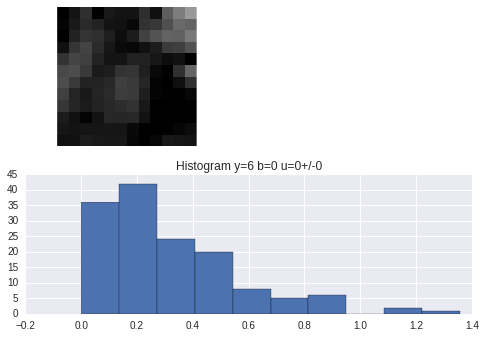

In [8]:

b=0
print A[:,6,:, b].mean(), np.std(A), i_hr[:,6,:, b].mean(), np.std(i_hr)

img_utils._ish(A, b=b, vmin=A.min(), vmax=A.max())
gtab.bvals[b]

(array([ 40.,  14.,  31.,  35.,  12.,   3.,   5.,   3.,   0.,   1.]),
 array([ 0.04373868,  0.19284255,  0.34194643,  0.4910503 ,  0.64015417,
         0.78925804,  0.93836191,  1.08746579,  1.23656966,  1.38567353,
         1.5347774 ]),
 <a list of 10 Patch objects>)

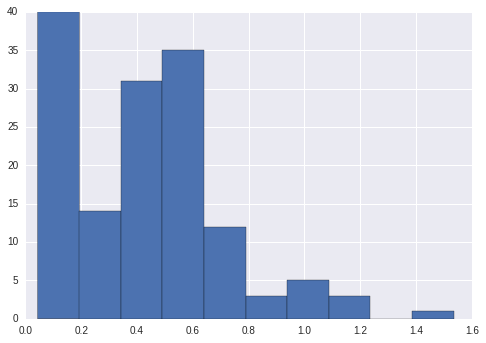

In [9]:
#hist(A[:,6,:, b].flatten(), range=(-0.03,0.15))
hist(i_hr[:,6,:, b].flatten())


recons (-0.00015426388, 0.28082418, 2.2698958) (12, 12, 12, 37)
orig (0.0020386195, 0.29971552, 3.2994506) (12, 12, 12, 37)
con la primer forma de tvnorm
dif_norm_hrs [46.376465]
Yhr_recons_norms [99.212112]
Yhr_norms [99.343712]
times [223.5637378692627]
optimal_vals [56.52688687012697]


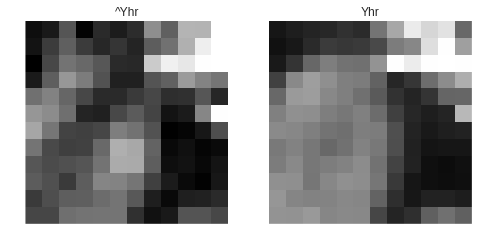

In [16]:

img_utils._isc(A, i_hr, b=b, vmin=0, vmax=1, titles=['^Yhr', 'Yhr'])


#img_utils._is(A, vmin=A.min(), vmax=A.max())
print 'recons', (A.min(), A.mean(), A.max()), A.shape
print 'orig',(i_hr.min(), i_hr.mean(), i_hr.max()), i_hr.shape
#G.shape

print 'con la primer forma de tvnorm'
print 'dif_norm_hrs', dif_norm_hrs
print 'Yhr_recons_norms', Yhr_recons_norms
print 'Yhr_norms', Yhr_norms
print 'times',times
print 'optimal_vals', optimal_vals

<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

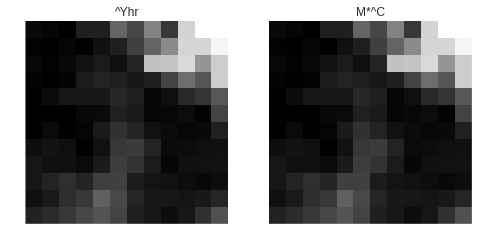

In [11]:
img_utils._isc(A, Amapl, b=4, vmin=0, vmax=1, titles=['^Yhr', 'M*^C'])


# HR Testing reconstruction 


mse= 0.0336395


((0, 1), (0, 1), 'mse=', (0, 0))

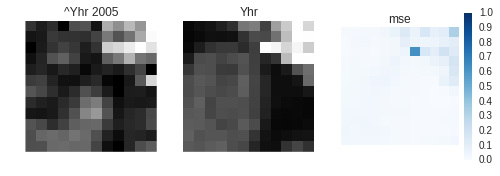

In [12]:
mse = ((A-i_hr)**2).mean(axis=3)
print 'mse=', ((A-i_hr)**2).mean()

bval = 5
titles = ['^Yhr '+str(int(gtab.bvals[bval])), 'Yhr', 'mse']
plt, _, _, im3 = img_utils._isc3(A, i_hr, mse,  b=bval,  vmin=[0, 0], vmax=[1, 1], titles=titles)
plt.colorbar(im3,fraction=0.056, pad=0.04)
mm(A[:,6,:, bval]), mm(i_hr[:,6,:, bval]), 'mse=', mm(mse)

In [13]:
def errrel_layers(A, B):
    err_rel = np.zeros(A.shape)
    for b in xrange(A.shape[3]):
        err_rel[:,:,:,b] = np.divide(np.abs(A[:,:,:,b]-B[:,:,:,b]), B[:,:,:,b]+0.01)
    return err_rel

(<Container object of 37 artists>,
 0.5447452689837452,
 0.81558315448007679,
 995.0)

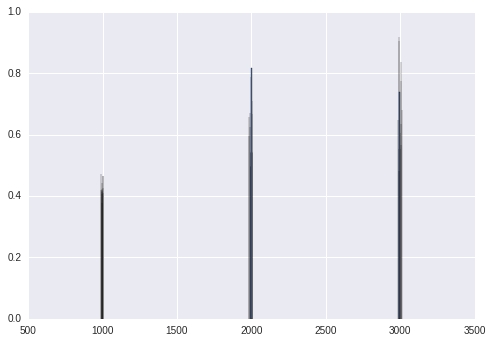

In [14]:
errel = errrel_layers(A, i_hr)
errs =[errel[:,:,:,b].mean() for b in xrange(A.shape[3])]

plt.bar(gtab.bvals, errs),errs[16], errs[32], gtab.bvals[b], #set(gtab.bvals)

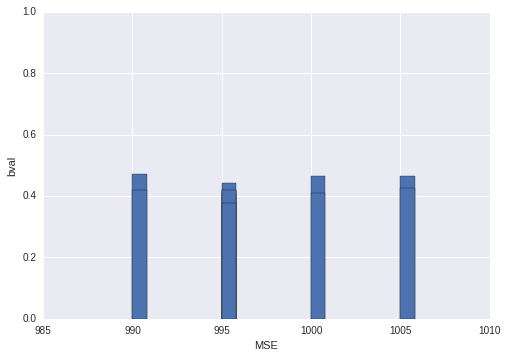

In [17]:
errel = errrel_layers(A, i_hr)
errs =[errel[:,:,:,b].mean() for b in xrange(A.shape[3])]

plt.bar(gtab.bvals, errs),errs[16], errs[32], gtab.bvals[b], #set(gtab.bvals
plt.xlim(985, 1010)
plt.xlabel('MSE')
plt.ylabel('bval')


990.0

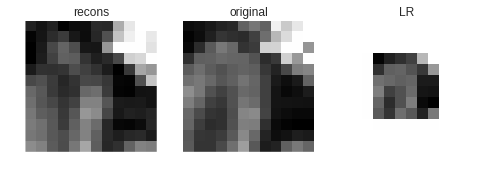

In [18]:
I_lr = np.ones(i_hr.shape)


for b in xrange(I_lr.shape[3]):
    I_lr[3:9,3:9,3:9,b] = i_lr[:, :, :, b]
b=6
plt, _, _, im3 = img_utils._isc3(A, i_hr, I_lr, b=b, vmax=1, titles=['recons', 'original', 'LR'])
plt.set_cmap('gray')
gtab.bvals[b]

# Testing Mapl reconstruction to clr

(6, 6, 6, 22) (6, 6, 6, 37)
(0, 0)
Error relativo max,min u std (0, 0) 0 0


<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

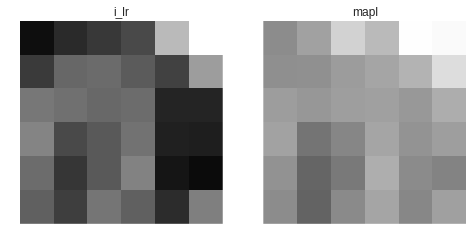

In [17]:
nx, ny, nz, Nb = i_lr.shape
Nb, Nc =  M.shape

_, C_lr, _ = get_sample_c(the_one_out, subjects, loader_func, scale=2)
print C_lr.shape, i_lr.shape
B = M.dot(C_lr.reshape((nx*ny*nz, Nc), order='F').T).T
B = B.reshape((nx, ny, nz, Nb), order='F')
    

err = np.abs(B - i_lr)
err_rel = np.divide(err, i_lr+1)#para q no de infinito

print mm(err) 
print 'Error relativo max,min u std', mm(err_rel), int(err_rel.mean()), \
                                      int(np.std(err_rel)) 

#img_utils._isc(i_hr, Eq_reconst,b=b, vmin=0, vmax=i_hr.max(), titles=['i_hr', 'cvxpy'])
img_utils._isc(i_lr, B,b=b, vmin=0, vmax=1, titles=['i_lr', 'mapl'])


(0, 5)
Error relativo max,min u std (0, 4) 0 0


<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

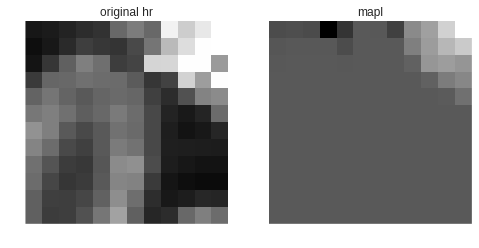

In [18]:
Nx, Ny, Nz, Nb = i_hr.shape
Nb, Nc =  M.shape

C_hr, _, _ = get_sample_c(the_one_out, subjects, loader_func, scale=2)
A_mapl = M.dot(C_hr.reshape((Nx*Ny*Nz, Nc), order='F').T).T
A_mapl = A.reshape((Nx, Ny, Nz, Nb), order='F')
    

err = np.abs(A_mapl - i_hr)
err_rel = np.divide(err, i_hr+1)#para q no de infinito

print mm(err) 
print 'Error relativo max,min u std', mm(err_rel), int(err_rel.mean()), \
                                      int(np.std(err_rel)) 

#img_utils._isc(i_hr, Eq_reconst,b=b, vmin=0, vmax=i_hr.max(), titles=['i_hr', 'cvxpy'])
img_utils._isc(i_hr, A_mapl,b=b, vmin=0, vmax=1, titles=['original hr', 'mapl'])


<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

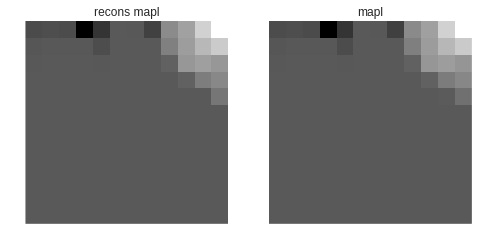

In [19]:
img_utils._isc(Amapl, A_mapl,b=b, vmin=0, vmax=1, titles=['recons mapl', 'mapl'])
